In [2]:

import pickle
import numpy as np

with open('../../PNC/AllSubjectsMeta.bin', 'rb') as f:
	meta = pickle.load(f)

with open('../../Work/Explainer/EmoidSplit1.bin', 'rb') as f:
	split = pickle.load(f)

with open('../../Work/Explainer/EmoidSplit1Ages.bin', 'rb') as f:
	ages = pickle.load(f)

def loadSeries(prefix,para,idx):
	with open(f'{prefix}/{para}_fmri_power264/timeseries/{idx}.bin', 'rb') as f:
		return pickle.load(f)

emoid_ts_train = [loadSeries('../../PNC', 'emoid', meta[Id]['emoid']) for Id in split['trainIds']]
emoid_ts_test = [loadSeries('../../PNC', 'emoid', meta[Id]['emoid']) for Id in split['testIds']]

print('Done loading')

emoid_p_train = np.stack([np.corrcoef(ts) for ts in emoid_ts_train])
emoid_p_test = np.stack([np.corrcoef(ts) for ts in emoid_ts_test])

print('Done FC')

Done loading
Done FC


In [3]:
import torch

emoid_p_t_train = torch.from_numpy(emoid_p_train).float().cuda()
emoid_p_t_test = torch.from_numpy(emoid_p_test).float().cuda()

print('Done torch')

Done torch


In [45]:
list(ages.keys())

['trainAges', 'testAges']

In [37]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import DenseGCNConv

nRoi = emoid_p_t_train.shape[1]
nHid = 100

def normalize(A):
    if A.shape[1] != A.shape[2]:
        raise Exception("Bad A shape")
    d = torch.abs(torch.sum(A,dim=2,keepdim=True))**0.5
    return ((A/d).permute(0,2,1)/d).permute(0,2,1)

# Cosine similarity
def calcEdges(ps):
    nRoi = ps.shape[1]
    e = torch.einsum('aij,ajk->aik',ps,ps)
    F = torch.einsum('aij,aij->ai',ps,ps)**0.5
    e = torch.einsum('aik,ai->aik',e,1/F)
    e = torch.einsum('aik,ak->aik',e,1/F)
    return normalize(e-torch.eye(nRoi).unsqueeze(0).float().cuda())

class MiniGCN(nn.Module):
    def __init__(self):
        super(MiniGCN, self).__init__()
        self.gc1 = DenseGCNConv(nRoi,nHid).float().cuda()
        self.gc2 = DenseGCNConv(nHid,5).float().cuda()
        self.fc1 = nn.Linear(5*nRoi,1).float().cuda()
        
    def forward(self, x):
        e = calcEdges(x)
        x = F.relu(self.gc1(x,e))
        x = F.relu(self.gc2(x,e))
        x = self.fc1(x.reshape(-1,5*nRoi))
        return x
    
gcn = MiniGCN()
optim = torch.optim.Adam(gcn.parameters(), lr=2e-4, weight_decay=0.2)

nEpoch = 2000
pPrint = 100

ages_t_train = torch.from_numpy(ages['trainAges']).float().cuda()

for epoch in range(nEpoch):
    optim.zero_grad()
    pred = gcn(emoid_p_t_train).flatten()
    loss = torch.mean((pred - ages_t_train)**2)**0.5
    loss.backward()
    optim.step()
    if epoch % pPrint == 0 or epoch == nEpoch-1:
        print(f'epoch {epoch} loss={loss}')
        
print('Complete')
        

epoch 0 loss=15.17326831817627
epoch 100 loss=5.892714023590088
epoch 200 loss=2.6970374584198
epoch 300 loss=2.1333746910095215
epoch 400 loss=1.9407477378845215
epoch 500 loss=1.8284605741500854
epoch 600 loss=1.7312767505645752
epoch 700 loss=1.6554044485092163
epoch 800 loss=1.5778415203094482
epoch 900 loss=1.516476035118103
epoch 1000 loss=1.467852234840393
epoch 1100 loss=1.3900216817855835
epoch 1200 loss=1.353518009185791
epoch 1300 loss=1.2717424631118774
epoch 1400 loss=1.2365984916687012
epoch 1500 loss=1.1976360082626343
epoch 1600 loss=1.1518051624298096
epoch 1700 loss=1.1047159433364868
epoch 1800 loss=1.0531917810440063
epoch 1900 loss=0.9910405278205872
epoch 1999 loss=0.9412136077880859
Complete


In [41]:
nHid = 100

def normalize(A):
    if A.shape[0] != A.shape[1]:
        raise Exception("Bad A shape")
    d = torch.sum(A,dim=1)**0.5
    return ((A/d).T/d).T

# Cosine similarity
def calcEdges(ps1, ps2):
    nB = ps1.shape[0]
    e = torch.einsum('aij,bij->ab',ps1,ps2)
    F1 = torch.einsum('aij,aij->a',ps1,ps1)**0.5
    F2 = torch.einsum('aij,aij->a',ps2,ps2)**0.5
    e /= F1.unsqueeze(1)
    e /= F2.unsqueeze(1).T
    return normalize(e-torch.eye(nB).float().cuda())

class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
#         self.fc1 = nn.Linear(nRoi*nRoi,nHid).float().cuda()
#         self.fc2 = nn.Linear(nHid,1).float().cuda()
#         self.ei = torch.ones(2,nSub*nSub).long().cuda()
        self.gc1 = DenseGCNConv(nRoi*nRoi,nHid).float().cuda()
        self.gc2 = DenseGCNConv(nHid,1).float().cuda()
        self.gc3 = DenseGCNConv(nHid,1).float().cuda()
        
    def forward(self, x):
#         nB = x[0].shape[0]
        A = x[1]
        x = x[0]
#         A = calcEdges(x, x)
#         x = x.reshape(nB,nRoi*nRoi)
        x = F.relu(self.gc1(x,A))
        x = F.relu(self.gc2(x,A))
#         x = self.gc3(x,A)
#         x = torch.einsum('ab,bf->af',L,x)
#         x = F.relu(self.fc1(x))
#         x = torch.einsum('ab,bf->af',L,x)
#         x = self.fc2(x)
        return x
    
gcn = GCN()
optim = torch.optim.Adam(gcn.parameters(), lr=1e-5, weight_decay=0.2)

nEpoch = 10000
pPrint = 500

x = emoid_p_t_train
A = calcEdges(x, x)
# xx = x.unsqueeze(0).reshape(1,-1,nRoi*nRoi)
# A = normalize((1/(torch.cdist(xx,xx)+torch.eye(nTrain).float().cuda())).squeeze(0))
z = x.reshape(-1,nRoi*nRoi)
goal = torch.from_numpy(ages['trainAges']).float().cuda()

for epoch in range(nEpoch):
    optim.zero_grad()
    pred = gcn([z,A]).flatten()
    loss = torch.mean((pred - goal)**2)**0.5
    loss.backward()
    optim.step()
    if epoch % pPrint == 0 or epoch == nEpoch-1:
        print(f'epoch {epoch} loss={loss}')
        
print('Complete')

epoch 0 loss=15.005074501037598
epoch 500 loss=2.6841063499450684
epoch 1000 loss=2.122899055480957
epoch 1500 loss=1.7693370580673218
epoch 2000 loss=1.5323901176452637
epoch 2500 loss=1.3921537399291992
epoch 3000 loss=1.3032944202423096
epoch 3500 loss=1.2250317335128784
epoch 4000 loss=1.175371527671814
epoch 4500 loss=1.128389596939087
epoch 5000 loss=1.0909227132797241
epoch 5500 loss=1.0533666610717773
epoch 6000 loss=1.0222290754318237
epoch 6500 loss=0.9861133098602295
epoch 7000 loss=0.9556182622909546
epoch 7500 loss=0.929192841053009
epoch 8000 loss=0.9031877517700195
epoch 8500 loss=0.8894373178482056
epoch 9000 loss=0.8637332916259766
epoch 9500 loss=0.8360279202461243
epoch 10000 loss=0.8128472566604614
epoch 10500 loss=0.8058125972747803


KeyboardInterrupt: 

In [53]:
w,_,_,_ = torch.linalg.lstsq(emoid_p_t_train.reshape(-1,nRoi*nRoi),torch.from_numpy(ages['trainAges']).float().cuda())

pred3 = emoid_p_t_test.reshape(-1,nRoi*nRoi)@w
pred3 = pred3[idcs].detach().cpu().numpy()

corr = np.corrcoef(y, pred3)
rmse = np.mean((y-pred3)**2)**0.5
mae = np.mean(np.abs(y-pred3))

print(corr)
print(rmse)
print(mae)

[[1.         0.75161661]
 [0.75161661 1.        ]]
2.108548688053306
1.6653249731250839


[[1.         0.75949335]
 [0.75949335 1.        ]]
2.0347851814749256
1.6290161656398399


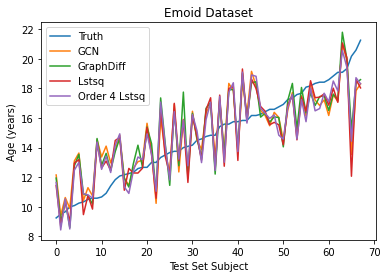

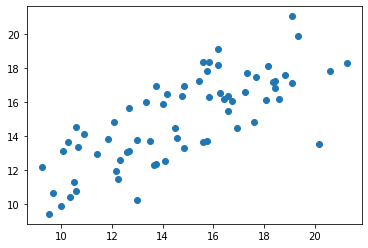

In [60]:
x = torch.cat([emoid_p_t_train, emoid_p_t_test],dim=0)
A = calcEdges(x, x)
# xx = x.unsqueeze(0).reshape(1,-1,nRoi*nRoi)
# A = normalize((1/(torch.cdist(xx,xx)+torch.eye(678).float().cuda())).squeeze(0))
z = x.reshape(-1,nRoi*nRoi)

pred2 = gcn([z,A])
pred2 = pred2.flatten()[emoid_p_t_train.shape[0]:].detach().cpu().numpy()
y = ages['testAges']
pred1 = am

idcs = np.argsort(y)
pred2 = pred2[idcs]
y = y[idcs]

corr = np.corrcoef(y, pred2)
rmse = np.mean((y-pred2)**2)**0.5
mae = np.mean(np.abs(y-pred2))

print(corr)
print(rmse)
print(mae)

plt.plot(y, label='Truth')
plt.plot(pred2, label='GCN')
plt.plot(pred1, label='GraphDiff')
plt.plot(pred3, label='Lstsq')
plt.plot(pred4, label='Order 4 Lstsq')
plt
plt.legend()
plt.xlabel('Test Set Subject')
plt.ylabel('Age (years)')
plt.title('Emoid Dataset')
plt.show()

plt.scatter(y, pred2)
plt.show()

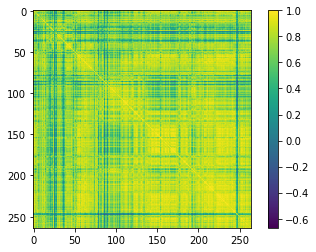

In [24]:
import matplotlib.pyplot as plt

e = calcEdges(emoid_p_t_train).detach().cpu().numpy()

plt.imshow(e[0])
plt.colorbar()
plt.show()

In [22]:
print(e[2,0:3,0:3])

[[0.9999999  1.0438293  0.3244931 ]
 [0.93212277 1.         0.2898021 ]
 [0.97658443 0.9767023  1.0000001 ]]


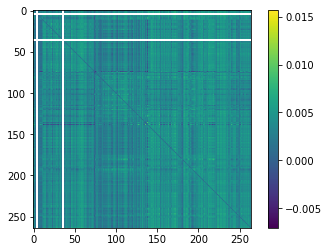

In [12]:
plt.imshow(e[2])
plt.colorbar()
plt.show()

In [47]:
import itertools
import random
import copy

nConnEdge = 264*264
# nHid = 30

class DiffGraph(nn.Module):
    def __init__(self):
        super(DiffGraph, self).__init__()
        self.fc = nn.Linear(2*nRoi*nRoi,1).float().cuda()
        
    def forward(self, x):
        return self.fc(x)
    
dg = DiffGraph()
optim = torch.optim.Adam(dg.parameters(), lr=5e-5, weight_decay=0.2)

nEpoch = 5
bSize = 1000
pPeriod = 10000

train = emoid_p_t_train.reshape(-1,264*264)
ages_train = torch.from_numpy(ages['trainAges']).float().cuda()

pairs = list(itertools.combinations_with_replacement(np.arange(train.shape[0]),2))

for i in range(nEpoch):
    randPairs = copy.copy(pairs)
    random.shuffle(randPairs)
    nComplete = 0
    print(f'epoch {i}')
    while nComplete < len(pairs):
        todo = len(pairs)-nComplete
        if todo > bSize:
            todo = bSize
        batchPairs = randPairs[nComplete:nComplete+todo]
        Ai, Bi = zip(*batchPairs)
        A = emoid_p_t_train[Ai,:,:]
        B = emoid_p_t_train[Bi,:,:]
        a = ages_train[list(Ai)]
        b = ages_train[list(Bi)]
        optim.zero_grad()
        pos = torch.cat([A,B],dim=1)
        neg = torch.cat([B,A],dim=1)
        posRes = dg(pos.reshape(-1,2*nRoi*nRoi)).flatten()
        negRes = dg(neg.reshape(-1,2*nRoi*nRoi)).flatten()
        posLoss = torch.mean((posRes-(a-b))**2)**0.5
        negLoss = torch.mean((negRes-(b-a))**2)**0.5
        (posLoss+negLoss).backward()
        optim.step()
        if nComplete % pPeriod == 0:
            print(f'\tposLoss={posLoss} negLoss={negLoss} complete={nComplete}')
        nComplete += todo
        
print('Complete')

epoch 0
	posLoss=5.023685455322266 negLoss=5.0110907554626465 complete=0
	posLoss=4.172796249389648 negLoss=4.180700778961182 complete=10000
	posLoss=4.00883150100708 negLoss=4.005923271179199 complete=20000
	posLoss=3.8868470191955566 negLoss=3.893165349960327 complete=30000
	posLoss=3.5684633255004883 negLoss=3.57639217376709 complete=40000
	posLoss=3.2637786865234375 negLoss=3.2698066234588623 complete=50000
	posLoss=2.9759674072265625 negLoss=2.9786932468414307 complete=60000
	posLoss=2.9283244609832764 negLoss=2.931443691253662 complete=70000
	posLoss=2.875917434692383 negLoss=2.8882946968078613 complete=80000
	posLoss=2.7048935890197754 negLoss=2.7141005992889404 complete=90000
	posLoss=2.4743731021881104 negLoss=2.4787046909332275 complete=100000
	posLoss=2.427255868911743 negLoss=2.4306204319000244 complete=110000
	posLoss=2.3381943702697754 negLoss=2.345111608505249 complete=120000
	posLoss=2.2146472930908203 negLoss=2.213740110397339 complete=130000
	posLoss=2.11232852935791 

In [49]:
# Test

ap = np.zeros(emoid_p_t_test.shape[0])
an = np.zeros(emoid_p_t_test.shape[0])
nTrain = emoid_p_t_train.shape[0]
ages_test = torch.from_numpy(ages['testAges']).float().cuda()

for i in range(emoid_p_t_test.shape[0]):
    if i % 20 == 0:
        print(f'done {i}')
    A = emoid_p_t_test[i].expand(nTrain,-1,-1)
    a = ages_test[i].expand(nTrain)

    B = emoid_p_t_train
    b = ages_train

    pos = torch.cat([A,B],dim=1)
    neg = torch.cat([B,A],dim=1)
    posRes = dg(pos.reshape(-1,2*nRoi*nRoi)).flatten()
    negRes = dg(neg.reshape(-1,2*nRoi*nRoi)).flatten()

    agePos = posRes + b
    ageNeg = b - negRes

    ap[i] = torch.mean(agePos).detach().cpu().numpy()
    an[i] = torch.mean(ageNeg).detach().cpu().numpy()
    
y = ages_test.detach().cpu().numpy()

idcs = np.argsort(y)
ap = ap[idcs]
an = an[idcs]
am = (ap+an)/2
y = y[idcs]

print('Positive')

corr = np.corrcoef(y, ap)
rmse = np.mean((y-ap)**2)**0.5
mae = np.mean(np.abs(y-ap))

print(corr)
print(rmse)
print(mae)

print('Negative')

corr = np.corrcoef(y, an)
rmse = np.mean((y-an)**2)**0.5
mae = np.mean(np.abs(y-an))

print(corr)
print(rmse)
print(mae)

print('Mean')

corr = np.corrcoef(y, am)
rmse = np.mean((y-am)**2)**0.5
mae = np.mean(np.abs(y-am))

print(corr)
print(rmse)
print(mae)

done 0
done 20
done 40
done 60
Positive
[[1.         0.77645204]
 [0.77645204 1.        ]]
2.0173047343608688
1.679147762410781
Negative
[[1.         0.77411388]
 [0.77411388 1.        ]]
2.0024905254052543
1.683029104681576
Mean
[[1.        0.7753176]
 [0.7753176 1.       ]]
2.0077690727949133
1.678054360782399


In [59]:
def makePoly(x, order):
    xs = [x]
    for i in range(1,order):
        xs.append(x*x)
    return torch.stack(xs,dim=x.dim())
    
e2_train = makePoly(emoid_p_t_train,4).reshape(-1,264*264*4)
e2_test = makePoly(emoid_p_t_test,4).reshape(-1,264*264*4)

print('Done poly')

w,_,_,_ = torch.linalg.lstsq(e2_train,torch.from_numpy(ages['trainAges']).float().cuda())

pred4 = e2_test@w
pred4 = pred4[idcs].detach().cpu().numpy()

corr = np.corrcoef(y, pred4)
rmse = np.mean((y-pred4)**2)**0.5
mae = np.mean(np.abs(y-pred4))

print(corr)
print(rmse)
print(mae)

Done poly
[[1.         0.78387726]
 [0.78387726 1.        ]]
1.9505585171057915
1.6064379355486704
